In [1]:
import torch
import os

import numpy as np
import matplotlib.pyplot as plt

from lstmxai.utils import load_and_preprocess, raw_data, LSTMModel, load_model, plot_ecg, normalize_array
from lstmxai.train import train_LSTM
from lstmxai.evaluate import evaluate_LSTM
from lstmxai.predict import predict
from lstmxai.attention import collect_attention_weights, plot_attention_weights
from lstmxai.saliency import compute_saliency_map, compute_all_saliency_maps

In [2]:
data_file = "./data/ecg5000.csv"

data, labels = raw_data(data_file)
train_loader, test_loader = load_and_preprocess(data_file)

In [3]:
# User input to choose whether to load an existing model or train a new one
user_input = input("Enter 'load' to load an existing model or 'train' to train a new one: ")

if user_input == "load":
    # List all .pth files in the ./models/ directory
    model_files = [file for file in os.listdir("./models/") if file.endswith(".pth")]
    if len(model_files) == 0:
        print("No model files found in the ./models/ directory.")
    else:
        print("Available model files:")
        for i, file in enumerate(model_files):
            print(f"{i+1}. {file}")
        model_index = int(input("Enter the index of the model file to load: ")) - 1
        if model_index < 0 or model_index >= len(model_files):
            print("Invalid model index.")
        else:
            model_path = os.path.join("./models/", model_files[model_index])
            loaded_model = load_model(model_path)
            print(f"Model loaded from {model_path}.")

elif user_input == "train":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTMModel(device = device)
    model.to(device)
    trained_model = train_LSTM(model, train_loader, test_loader, n_epochs=150)
    loaded_model = load_model(trained_model)
    print(f"Loaded the new model trained from scratch. Saved to {trained_model}.")

else:
    print("Invalid input. Please enter 'load' or 'train'.")

Available model files:
1. LSTM_0.9413.pth
LSTM Model Config: {'Input Layer Dimensions': 1, 'Hidden Layer Dimensions': 80, 'Number of Layers:': 3, 'Output Dimensions': 1, 'Model on device': device(type='cpu')}
Model loaded from ./models/LSTM_0.9413.pth.


In [4]:
evaluate_LSTM(loaded_model, test_loader)

{'accuracy': 0.9413333333333334,
 'precision': 0.9089026915113871,
 'recall': 1.0,
 'f1': 0.9522776572668112}

In [5]:
attention_weights = collect_attention_weights(loaded_model, test_loader)

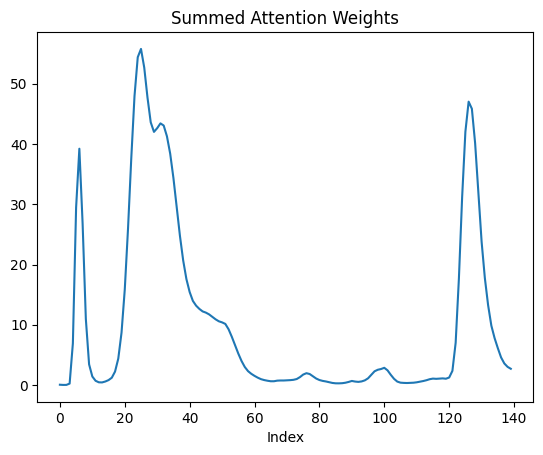

In [6]:
# Plot the summed attention weights
attention_sum = np.sum(attention_weights, axis=0)
plt.plot(attention_sum)
plt.xlabel('Index')
plt.title('Summed Attention Weights')
plt.show()

In [7]:
saliency_maps = compute_all_saliency_maps(loaded_model, test_loader)

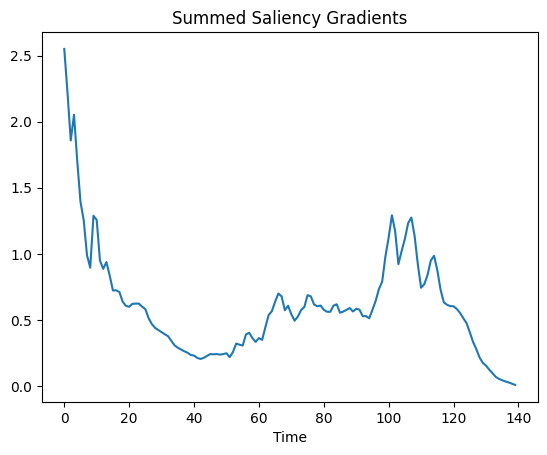

In [8]:
# Plot the summed saliency maps
saliency_sum = np.sum(saliency_maps, axis=0)
plt.plot(saliency_sum)
plt.xlabel('Time')
plt.title('Summed Saliency Gradients')
plt.show()

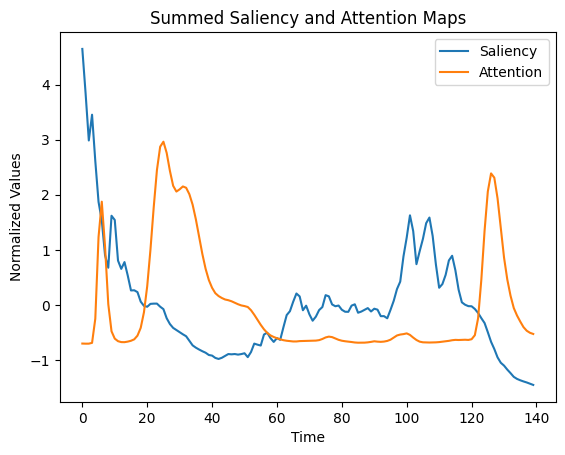

In [9]:
summed_saliency_map = normalize_array(np.sum(saliency_maps, axis=0))
summed_attention_map = normalize_array(np.sum(attention_weights, axis=0))

plt.plot(summed_saliency_map)
plt.plot(summed_attention_map)
plt.xlabel('Time')
plt.ylabel('Normalized Values')
plt.title('Summed Saliency and Attention Maps')
plt.legend(['Saliency', 'Attention'])
plt.show()

Area of Saliency: 92.86808147033055
Area of Attention: 108.64060395210981
Area of Intersection: 87.04600403706232
Percentage Overlap: 76.04749686405823


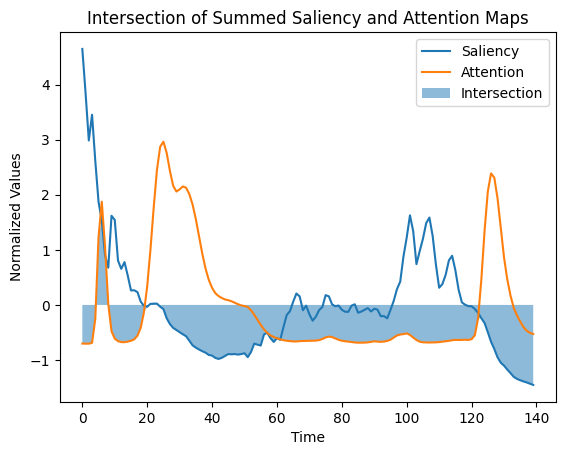

In [11]:
from scipy.integrate import simpson

summed_saliency_map = normalize_array(np.sum(saliency_maps, axis=0))
summed_attention_map = normalize_array(np.sum(attention_weights, axis=0))

# Calculate the area of intersection
area_saliency = abs(simpson(np.minimum(summed_saliency_map, 0))) + abs(simpson(np.maximum(summed_saliency_map, 0)))
area_attention = abs(simpson(np.minimum(summed_attention_map, 0))) + abs(simpson(np.maximum(summed_attention_map, 0)))
area_intersection = abs(simpson(np.minimum(summed_saliency_map, summed_attention_map)))

# Print the area of intersection
print("Area of Saliency:", area_saliency)
print("Area of Attention:", area_attention)
print("Area of Intersection:", area_intersection)
print("Percentage Overlap:", (area_intersection / (area_saliency + area_attention - area_intersection))*100)

plt.plot(summed_saliency_map)
plt.plot(summed_attention_map)
# plt.plot(np.minimum(summed_saliency_map, summed_attention_map))
plt.fill_between(np.arange(len(summed_saliency_map)), np.minimum(summed_saliency_map, summed_attention_map), alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Normalized Values')
plt.title('Intersection of Summed Saliency and Attention Maps')
plt.legend(['Saliency', 'Attention', 'Intersection'])
plt.show()